In [1]:
# Imports
import json
import numpy as np
import math
import random
import torch
import pandas as pd
import random
from sklearn.model_selection import train_test_split
!pip install transformers
from transformers import BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import matplotlib.pyplot as plt
from collections import Counter

In [20]:
# Read in data file

# Opening JSON file
reviews = open('Clothing_Shoes_and_Jewelry_5.json',) 

# returns JSON object as  
# a dictionary 
data = json.loads(reviews.read())

In [21]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [24]:
# Iterate through data points and grab reviews
sentences = []; ratings = []
for review in data["reviews"]:
    # Append to sentences
    sentences.append(review['reviewText'])
    ratings.append(review['overall'])

Text(0, 0.5, 'Count')

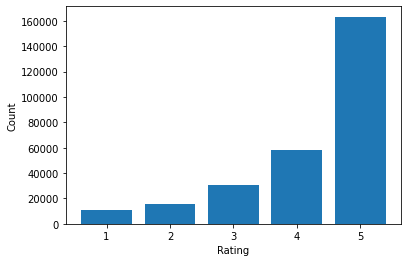

In [39]:
# Plotting bar chart of labels
ratingsToPlot = Counter(ratings)
plt.bar(ratingsToPlot.keys(), ratingsToPlot.values(), align='center')
plt.xlabel('Rating')
plt.ylabel('Count')

In [ ]:
# Formatting labels
ratings = [rating - 1 for rating in ratings]

In [6]:
# Tokenizing
# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
# For every sentence...
for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Showing an example of the tokenized sentences
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


Original:  This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++
Token IDs: [101, 2023, 2003, 1037, 2307, 10722, 8525, 1998, 2012, 1037, 2428, 2307, 3976, 1012, 2009, 2987, 1005, 1056, 2298, 10036, 2012, 2035, 1012, 1045, 1005, 1049, 2061, 5580, 1045, 2246, 2006, 9733, 1998, 2179, 2107, 2019, 15184, 10722, 8525, 2008, 3475, 1005, 1056, 2081, 9996, 1012, 1037, 1009, 1009, 102]


In [7]:
# Padding
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

MAX_LEN = 512 # MAX that BERT model can accept
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
print('\Done.')

Max sentence length:  5417

Padding/truncating all sentences to 512 values...

Padding token: "[PAD]", ID: 0
\Done.


In [8]:
# Create attention masks
attention_masks = []
# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [9]:
# Data splitting

# Splitting data into train and test (4:1)
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, ratings, 
                                                            random_state=1000, test_size=0.1)
# Do the same for the masks.
train_masks, test_masks, _, _ = train_test_split(attention_masks, ratings,
                                                 random_state=1000, test_size=0.1)

# Splitting training data into train set and validation set
partial_train_inputs, partial_validation_inputs, partial_train_labels, partial_validation_labels = train_test_split(train_inputs, train_labels, 
                                                            random_state=2000, test_size=0.1)
# Do the same for the masks.
partial_train_masks, partial_validation_masks, _, _ = train_test_split(train_masks, train_labels,
                                             random_state=2000, test_size=0.1)

In [10]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
partial_train_inputs = torch.tensor(partial_train_inputs)
partial_validation_inputs = torch.tensor(partial_validation_inputs)
test_inputs = torch.tensor(test_inputs)

partial_train_labels = torch.tensor(partial_train_labels).type(torch.LongTensor)
partial_validation_labels = torch.tensor(partial_validation_labels).type(torch.LongTensor)
test_labels = torch.tensor(test_labels).type(torch.LongTensor)

partial_train_masks = torch.tensor(partial_train_masks)
partial_validation_masks = torch.tensor(partial_validation_masks)
test_masks = torch.tensor(test_masks)

In [11]:
# Doing the data loaders for the three sets
batch_size = 15
# Create the DataLoader for our training set.
train_data = TensorDataset(partial_train_inputs, partial_train_masks, partial_train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(partial_validation_inputs, partial_validation_masks, partial_validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for our testing set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [12]:
# BERT Model
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, # 5 classes  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [13]:
# Adam Optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

# Number of training epochs
epochs = 2
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [14]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [15]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [16]:
# TRAINING
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# Store the average loss after each epoch so we can plot them.
loss_values = []
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    # Put the model into training mode. 
    model.train()
    # For each batch of training data...
    eval_train_accuracy = 0
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        # Unpack this training batch from our dataloader
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clearing any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()

        # Evaluate the model on this training batch
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
        
        # Get the "logits" output by the model.
        logits = outputs[1]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_train_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_train_accuracy += tmp_train_eval_accuracy

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Calculate the average loss over the training data.
    avg_train_acc = eval_train_accuracy / len(train_dataloader)  

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Average training accuracy: {0:.2f}".format(avg_train_acc))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Not computing gradients during validation
        with torch.no_grad():
            # Evaluate the model on this validation batch
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  5,400.    Elapsed: 0:00:52.
  Batch    80  of  5,400.    Elapsed: 0:01:46.
  Batch   120  of  5,400.    Elapsed: 0:02:45.
  Batch   160  of  5,400.    Elapsed: 0:03:45.
  Batch   200  of  5,400.    Elapsed: 0:04:45.
  Batch   240  of  5,400.    Elapsed: 0:05:45.
  Batch   280  of  5,400.    Elapsed: 0:06:45.
  Batch   320  of  5,400.    Elapsed: 0:07:45.
  Batch   360  of  5,400.    Elapsed: 0:08:45.
  Batch   400  of  5,400.    Elapsed: 0:09:45.
  Batch   440  of  5,400.    Elapsed: 0:10:45.
  Batch   480  of  5,400.    Elapsed: 0:11:45.
  Batch   520  of  5,400.    Elapsed: 0:12:45.
  Batch   560  of  5,400.    Elapsed: 0:13:45.
  Batch   600  of  5,400.    Elapsed: 0:14:45.
  Batch   640  of  5,400.    Elapsed: 0:15:45.
  Batch   680  of  5,400.    Elapsed: 0:16:45.
  Batch   720  of  5,400.    Elapsed: 0:17:45.
  Batch   760  of  5,400.    Elapsed: 0:18:45.
  Batch   800  of  5,400.    Elapsed: 0:19:44.
  Batch   840  of

In [18]:
# Test Set
print("Running Testing...")
t0 = time.time()
# Put the model in evaluation mode--the dropout layers behave differently
# during evaluation.
model.eval()
# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

for batch in test_dataloader:
        
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
        
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
        
  # Not computing gradients during testing
  with torch.no_grad():
    # Evaluate the model on this testing batch
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
    # Get the "logits" output by the model
    logits = outputs[0]
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
    # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy
    # Track the number of batches
    nb_eval_steps += 1

# Report the final accuracy for testing.
print("  Testing Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  Testing took: {:}".format(format_time(time.time() - t0)))

Running Testing...
  Testing Accuracy: 0.75
  Testing took: 0:06:15
